In [2]:
%cd /data3/yokoyama/labvideo
import os
import sys
import shutil
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml

sys.path.append(".")
from src.utils import json_handler, video, yaml_handler

/data3/yokoyama/labvideo


/data3/yokoyama/anaconda3/envs/labvideo/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
config = yaml_handler.load("datasets/yolov8_finetuning/yolov8_finetuning.yaml")
classes = config.names.__dict__
classes

{'0': 'centrifuge tube',
 '1': 'centrifuge tube cap',
 '2': 'culture dish',
 '3': 'pipette',
 '4': 'dispenser',
 '5': 'hand'}

In [5]:
video_name = "Failures10"
# th_move = 4.55
th_move = 1.0

ann_data = np.loadtxt(f"out/{video_name}/{video_name}_ann.tsv", skiprows=1, dtype=str)
yolo_preds = np.loadtxt(
    f"out/{video_name}/{video_name}_det_finetuned_thmove{th_move:.2f}.tsv",
    skiprows=1,
    dtype=float,
)

cap = video.Capture(f"video/{video_name}.mp4")
frame_count = cap.frame_count
frame_size = cap.size
del cap

In [6]:
ann_unique_labels = np.unique(ann_data[:, 8])
ann_timings = {ann_label: 0 for ann_label in ann_unique_labels}
for ann_label in ann_unique_labels:
    ann_tmp = ann_data[ann_data[:, 8] == ann_label]
    n_frame = int(ann_tmp[0, 0])
    ann_timings[ann_label] = n_frame

ann_timings

{'1(A34)': 1604, '2(C31)': 1871, '3(A36)': 2460}

# 物体の出現タイミング・頻度

In [7]:
last_n_frame = int(np.max(yolo_preds[:, 0]))
counts_dict = {
    int(label): [0 for n_frame in range(last_n_frame + 1)] for label in classes.keys()
}

for pred in yolo_preds:
    n_frame = int(pred[0])
    label = int(pred[6])

    counts_dict[label][n_frame] += 1

# max_n_counts = 0
# for counts in counts_dict.values():
#     if np.max(counts) > max_n_counts:
#         max_n_counts = np.max(counts)
# print("max_n_counts", max_n_counts)

In [8]:
def create_legend(max_n_counts, marker_scale=100):
    counts = np.arange(max_n_counts + 1)
    fig = plt.figure()
    ax = fig.subplots(1, 1)
    for c in counts:
        if c < max_n_counts:
            label = c
        else:
            label = f"{c}~"
        ax.scatter(
            c,
            c,
            c * marker_scale,
            marker="|",
            linewidth=c / 5,
            color="black",
            label=label,
        )
    hans, labs = ax.get_legend_handles_labels()
    plt.close()

    return hans, labs

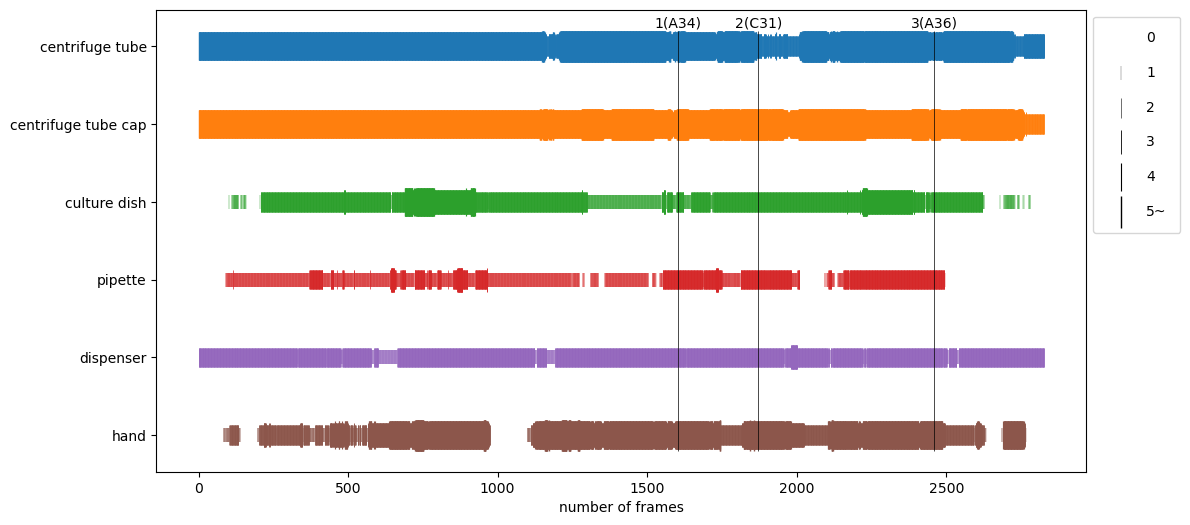

In [9]:
max_n_counts = 5
marker_scale = 100

# plot object counts
fig = plt.figure(figsize=(12, 6))
ax = fig.subplots(1, 1)

for label, counts in counts_dict.items():
    y = np.full((len(counts),), len(classes) - (label + 1))
    x = np.arange(len(counts))
    counts = np.array(counts).astype(float)
    counts[counts > max_n_counts] = max_n_counts
    s = counts * marker_scale
    lw = (counts + 1) / (max_n_counts + 1)
    ax.scatter(x, y, label=classes[str(label)], marker="|", s=s, linewidths=lw)

# plot annotation timing
for label, n_frame in ann_timings.items():
    ax.vlines([n_frame], -0.2, len(classes) - 1 + 0.2, color="black", lw=0.5)
    ax.text(n_frame, len(classes) - 1 + 0.25, label, horizontalalignment="center")

ax.set_xlabel("number of frames")
ticks = [len(classes) - (int(k) + 1) for k in classes.keys()]
ax.set_yticks(ticks, list(classes.values()))

hans, labs = create_legend(max_n_counts, marker_scale)
ax.legend(
    hans,
    labs,
    loc="upper left",
    bbox_to_anchor=(1.0, 1.0),
    borderpad=1.0,
    labelspacing=1.5,
)

plt.show()

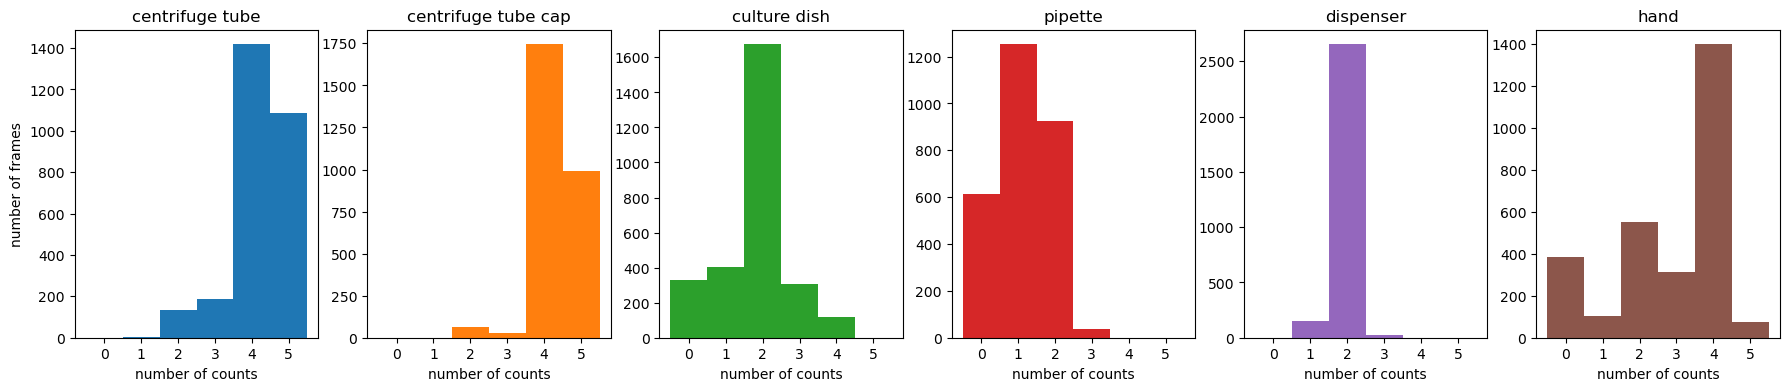

In [10]:
# max_n_counts = 0
# for counts in counts_dict.values():
#     if np.max(counts) > max_n_counts:
#         max_n_counts = np.max(counts)
# print("max_n_counts", max_n_counts)
max_n_counts = 5
labels = list(classes.values())
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(1, len(labels), figsize=(22, 4))
for i, label in enumerate(labels):
    counts_hist = np.array(counts_dict[i])
    counts_hist[counts_hist > max_n_counts] = max_n_counts

    c = cmap(i)

    axs[i].hist(
        counts_hist,
        bins=max_n_counts + 1,
        range=(0, max_n_counts + 1),
        color=c,
        label=label,
    )
    axs[i].set_xlabel("number of counts")
    axs[i].set_xticks(
        [0.5 + i for i in range(max_n_counts + 1)], list(range(max_n_counts + 1))
    )
    axs[i].set_title(label)
axs[0].set_ylabel("number of frames")
plt.show()

# 動いている物体のみ

In [11]:
# 動き有りバージョン
last_n_frame = int(np.max(yolo_preds[:, 0]))
counts_dict_move = {
    int(label): [0 for n_frame in range(last_n_frame + 1)] for label in classes.keys()
}

for pred in yolo_preds:
    n_frame = int(pred[0])
    label = int(pred[6])
    is_move = bool(pred[-1])

    if is_move:
        counts_dict_move[label][n_frame] += 1

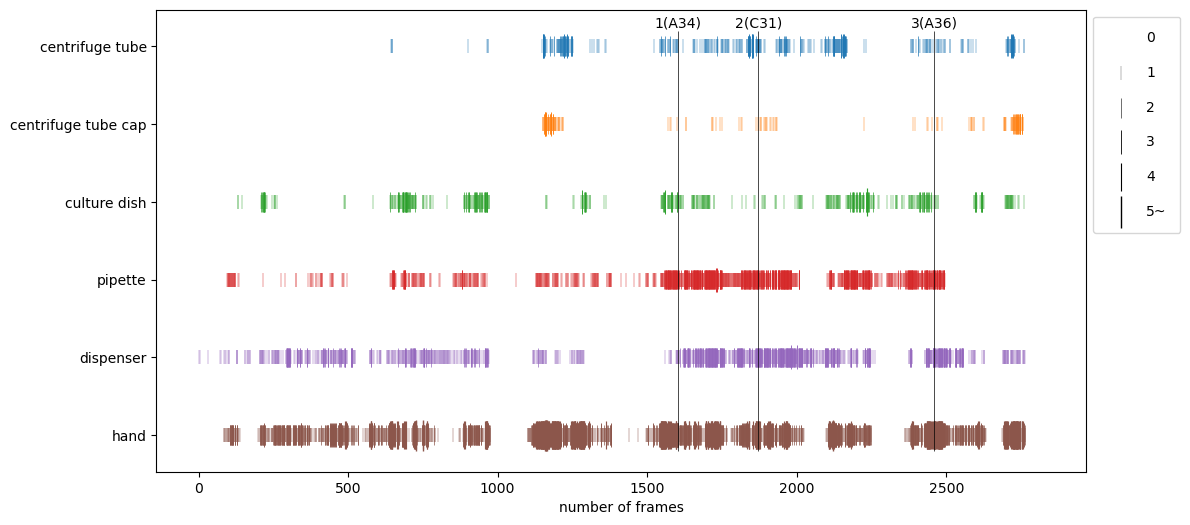

In [12]:
fig = plt.figure(figsize=(12, 6))
ax = fig.subplots(1, 1)

for label, counts in counts_dict_move.items():
    y = np.full((len(counts),), len(classes) - (label + 1))
    x = np.arange(len(counts))
    counts = np.array(counts).astype(float)
    counts[counts > max_n_counts] = max_n_counts
    s = counts * marker_scale
    lw = (counts + 1) / (max_n_counts + 1)
    ax.scatter(x, y, label=classes[str(label)], marker="|", s=s, linewidths=lw)

# plot annotation timing
for label, n_frame in ann_timings.items():
    ax.vlines([n_frame], -0.2, len(classes) - 1 + 0.2, color="black", lw=0.5)
    ax.text(n_frame, len(classes) - 1 + 0.25, label, horizontalalignment="center")

ax.set_xlabel("number of frames")
ticks = [len(classes) - (int(k) + 1) for k in classes.keys()]
ax.set_yticks(ticks, list(classes.values()))

hans, labs = create_legend(max_n_counts, marker_scale)
ax.legend(
    hans,
    labs,
    loc="upper left",
    bbox_to_anchor=(1.0, 1.0),
    borderpad=1.0,
    labelspacing=1.5,
)

plt.show()

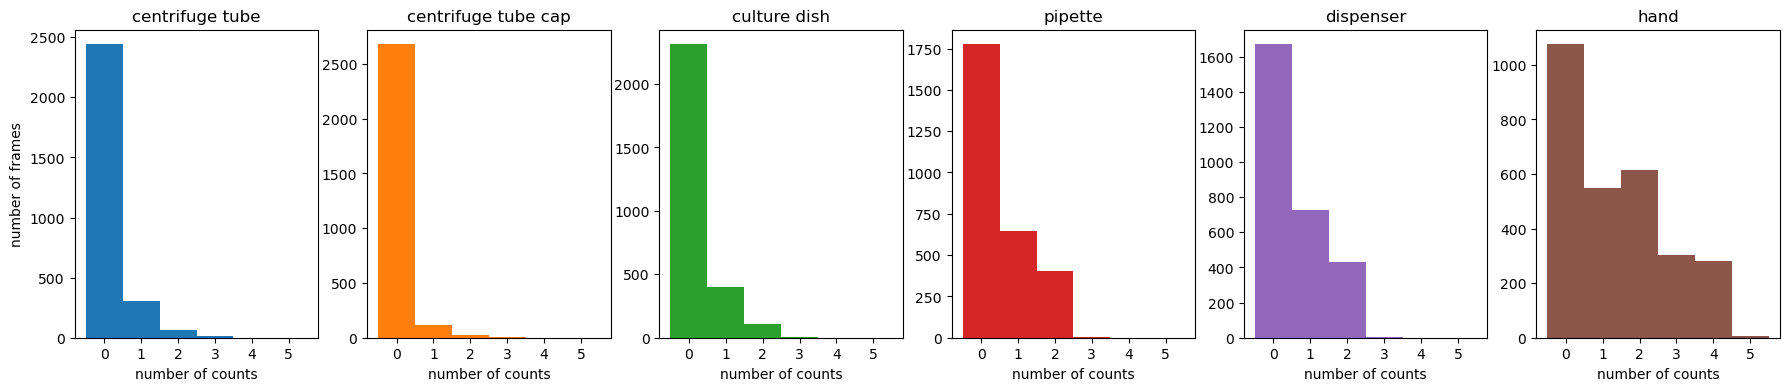

In [13]:
# TODO　物体ごとに動いているかどうかのヒストグラム
# max_n_counts = 0
# for counts in counts_dict_move.values():
#     if np.max(counts) > max_n_counts:
#         max_n_counts = np.max(counts)
# print("max_n_counts", max_n_counts)

fig, axs = plt.subplots(1, len(labels), figsize=(22, 4))
for i, label in enumerate(labels):
    counts_hist = np.array(counts_dict_move[i])
    counts_hist[counts_hist > max_n_counts] = max_n_counts

    c = cmap(i)

    axs[i].hist(
        counts_hist,
        bins=max_n_counts + 1,
        range=(0, max_n_counts + 1),
        color=c,
        label=label,
    )
    axs[i].set_xlabel("number of counts")
    axs[i].set_xticks(
        [0.5 + i for i in range(max_n_counts + 1)], list(range(max_n_counts + 1))
    )
    axs[i].set_title(label)
axs[0].set_ylabel("number of frames")
plt.show()

# 異常発生場所のアノテーションと物体認識結果の分析
- 異常発生時とそうでない時の物体の配置の分布の違い
- 異常発生までの各物体の移動経路

In [13]:
ann_frames = {ann_label: None for ann_label in ann_unique_labels}

cap = video.Capture(f"video/{video_name}.mp4")
for ann_label, n_frame in ann_timings.items():
    cap.set_pos_frame_count(n_frame)
    ret, frame = cap.read()
    if ret == False:
        raise ValueError
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ann_frames[ann_label] = frame

del cap